In [358]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [359]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [360]:
hdf_dir = Path("../data")

In [361]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [362]:
fname = "2021_4_19.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<80} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1618862432 scan R0 F1 F 1 F1 0.5                                                 : 251
1  <> 1618862608 scan R0 F1 F 1 F1 0.5                                                 : 681
2  <> 1618863356 scan P2 F1 (with R0 F1 DET)                                           : 1
3  <> 1618863431 scan P2 F1 (with R0 F1 DET)                                           : 921
4  <> 1618864013 scan P2 F1 ratio (with R0 F1 DET)                                     : 10201
5  <> 1618866727 scan P2 F1 ratio with phase modulation (with R0 F1 DET)               : 10201
6  <> 1618869079 scan P2 F1 ratio with phase modulation (with R0 F1 DET)               : 1
7  <> 1618869249 scan P2 F1 ratio with phase modulation (with R0 F1 DET)               : 3601
8  <> 1618870423 scan R0 F1 ratio with phase modulation (with R0 F1 DET)               : 1
9  <> 1618870453 scan R0 F1 ratio with phase modulation (with R0 F1 DET)               : 15101
10 <> 1618873694 scan P2 F1 ratio with phase modulation (with R0 F1 D

## Scan R0 F1

In [363]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [364]:
dset_idx = 1
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

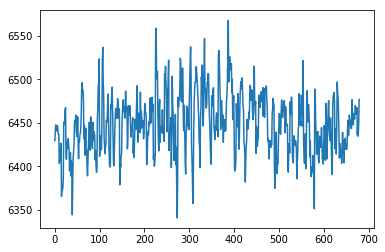

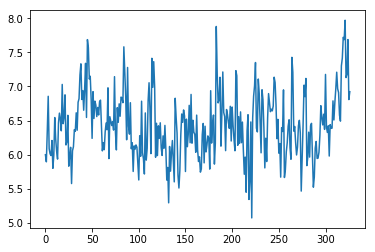

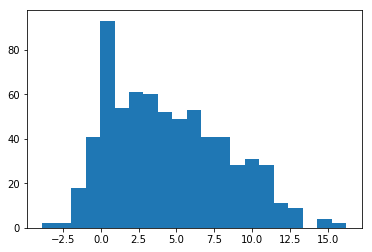

In [365]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [366]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 3
fl_cutoff = -5000

In [367]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

45.9% data discarded


In [368]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

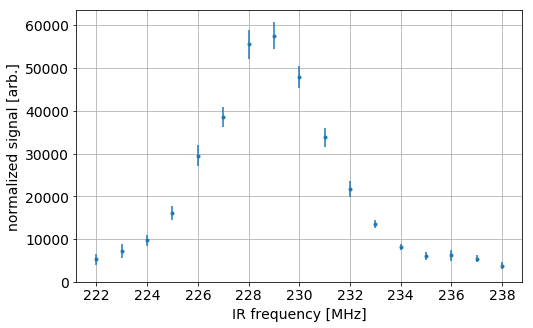

In [369]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

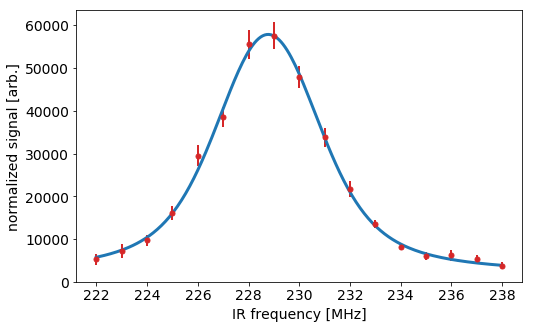

In [396]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)

## Scan P2 F1

In [398]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [399]:
dset_idx = 3
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

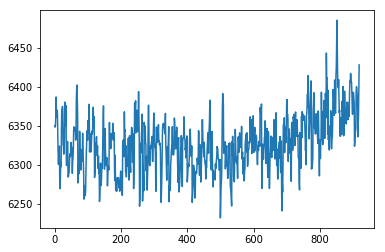

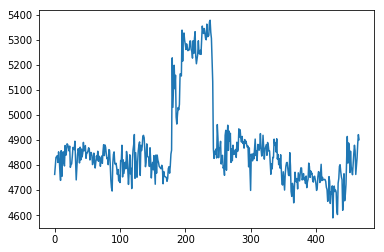

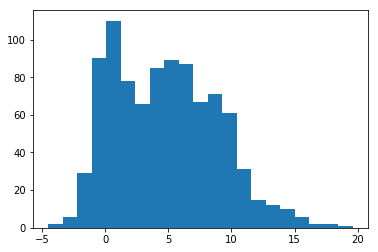

In [400]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [401]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 3
fl_cutoff = -5000

In [402]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

41.1% data discarded


In [403]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

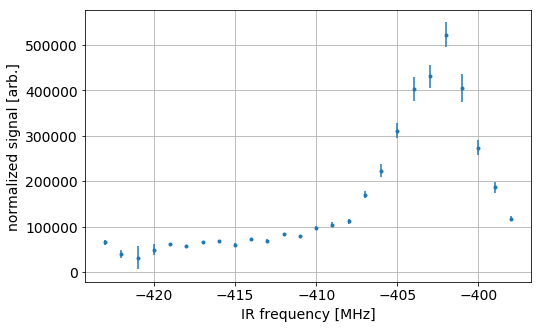

In [404]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

2.548375280472405

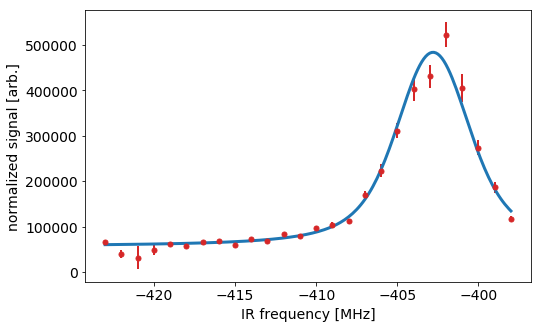

In [408]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
result.redchi

## Scan P2 F1 RC with R0 F1 10 mW DET power

In [46]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [48]:
dset_idx = 4
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
         
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

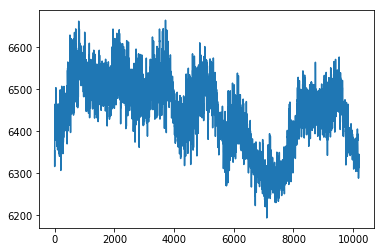

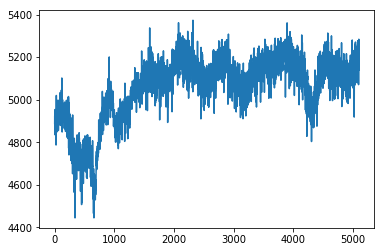

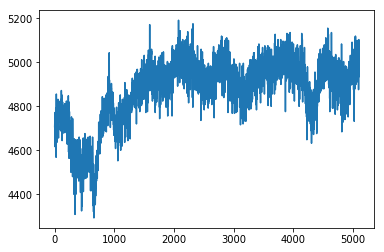

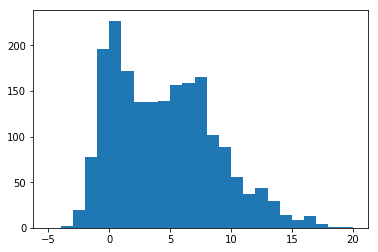

In [49]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [57]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -5000

In [58]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

56.9% data discarded


In [59]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

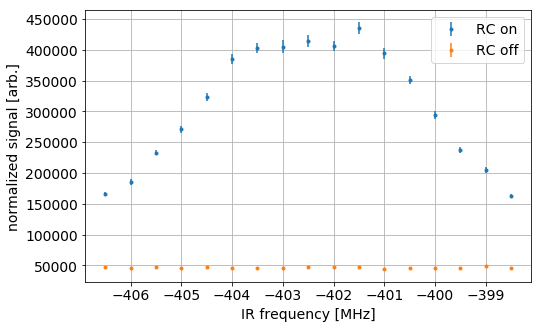

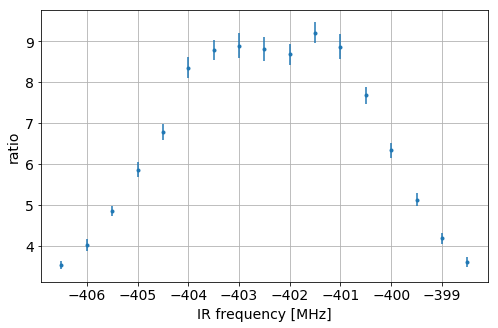

In [60]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [61]:
scan = {}
scan[dset_idx] = (bin_means, results)

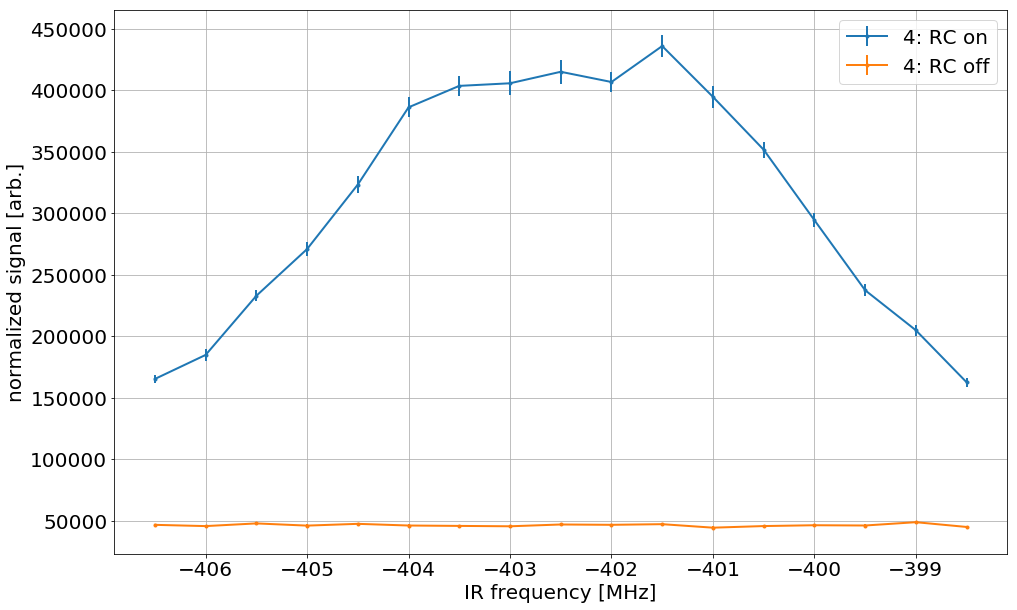

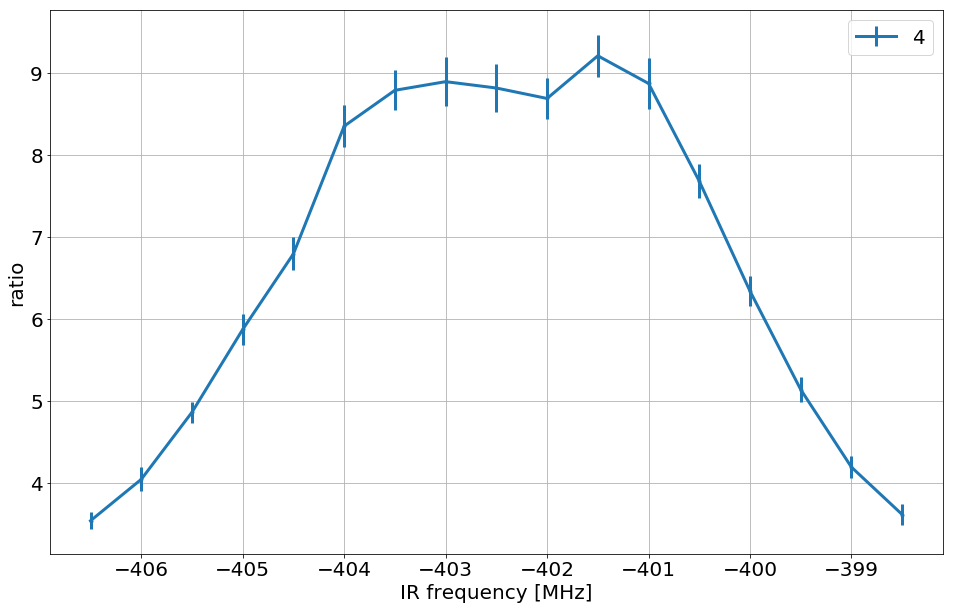

In [64]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm,r) in scan.items():
    ax.errorbar(bm, r[0][0], yerr = r[0][1], fmt = '.', label = f'{s}: RC on', lw = 2, ls = '-')
    ax.errorbar(bm, r[1][0], yerr = r[1][1], fmt = '.', label = f'{s}: RC off', lw = 2, ls = '-')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 20)

ax.grid(True)
set_fontsize(ax, 20)

fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan.items():
    ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
    ax.errorbar(bm, ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)

set_fontsize(ax, 20)

## Scan P2 F1 RC with R0 F1 10 mW DET power
With phase modulation $\beta\approx 3.8$  
88 mW on RC after measurement

In [65]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [68]:
dset_idx = 5
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
         
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

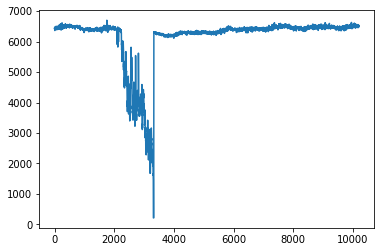

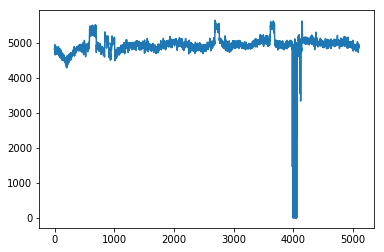

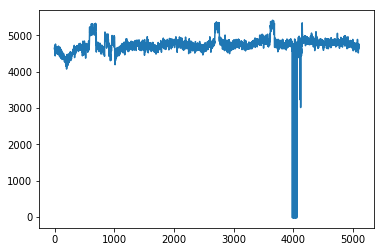

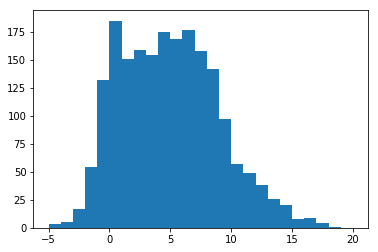

In [69]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [83]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 6
fl_cutoff = -5000

In [84]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

70.2% data discarded


In [85]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

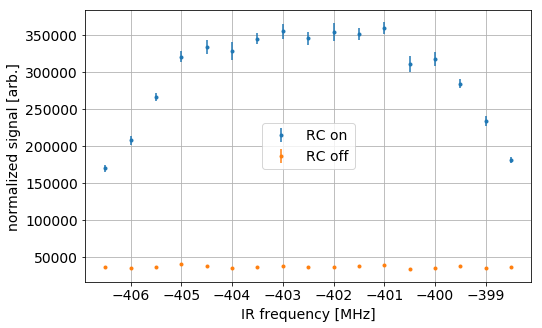

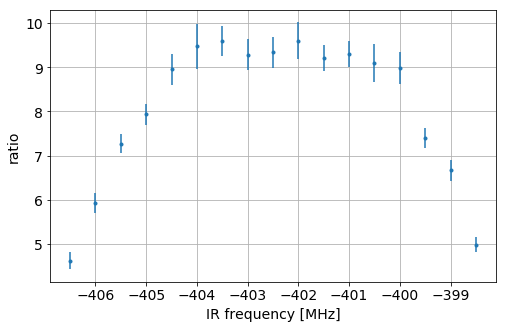

In [86]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [87]:
scan[dset_idx] = (bin_means, results)

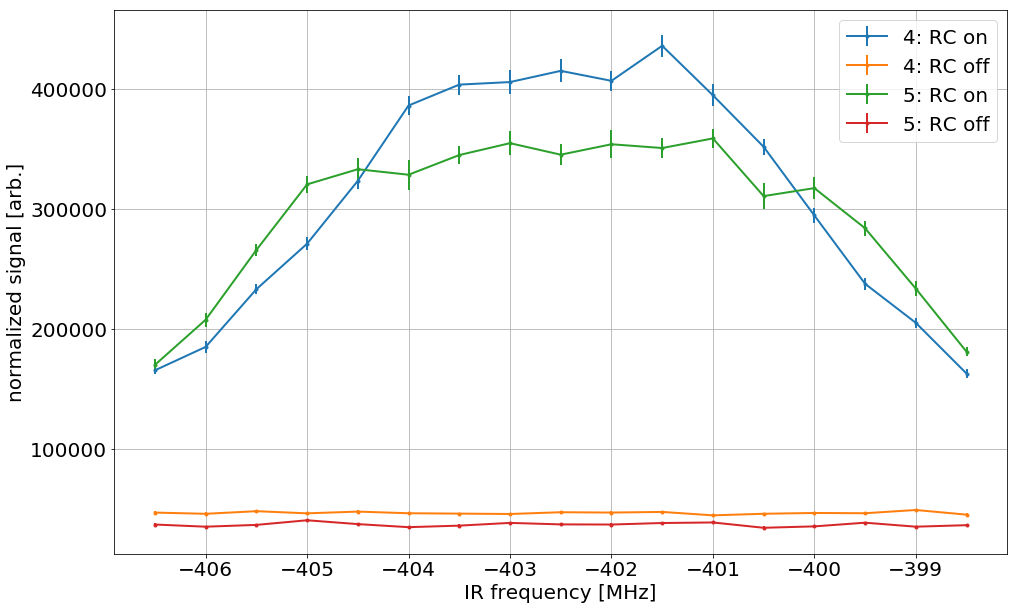

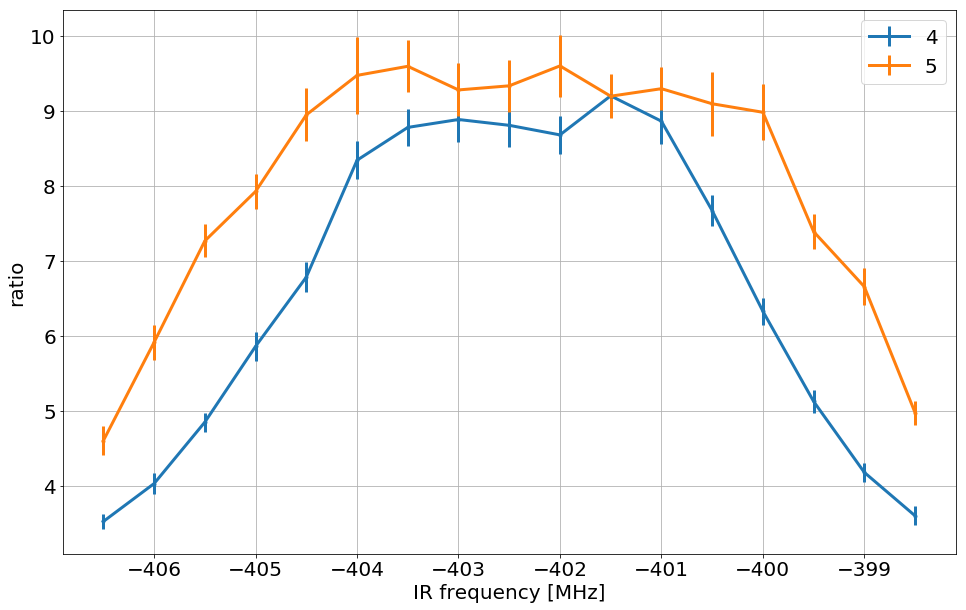

In [88]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm,r) in scan.items():
    ax.errorbar(bm, r[0][0], yerr = r[0][1], fmt = '.', label = f'{s}: RC on', lw = 2, ls = '-')
    ax.errorbar(bm, r[1][0], yerr = r[1][1], fmt = '.', label = f'{s}: RC off', lw = 2, ls = '-')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 20)

ax.grid(True)
set_fontsize(ax, 20)

fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan.items():
    ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
    ax.errorbar(bm, ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)

set_fontsize(ax, 20)

## Scan P2 F1 RC with R0 F1 10 mW DET power 
With phase modulation $\beta\approx 3.8$  
wide scan

In [153]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [154]:
dset_idx = 7
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
         
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

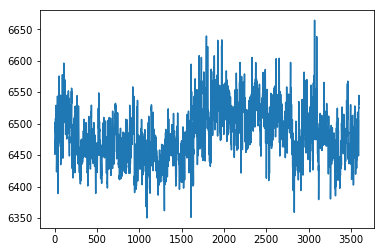

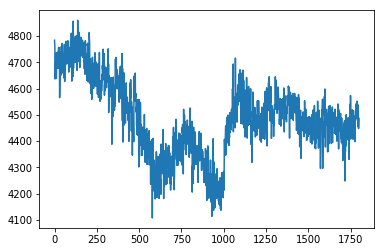

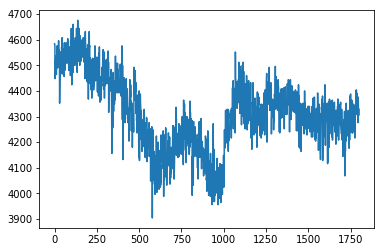

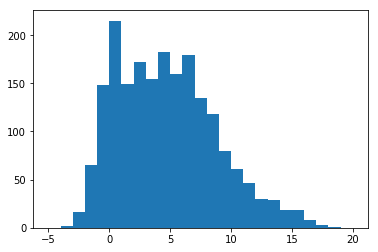

In [155]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [156]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -5000

In [157]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

57.0% data discarded


In [158]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

(0.8, 1.5)

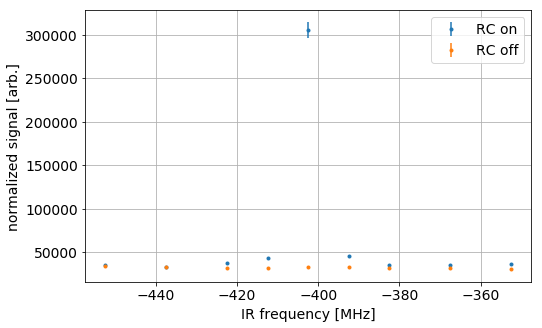

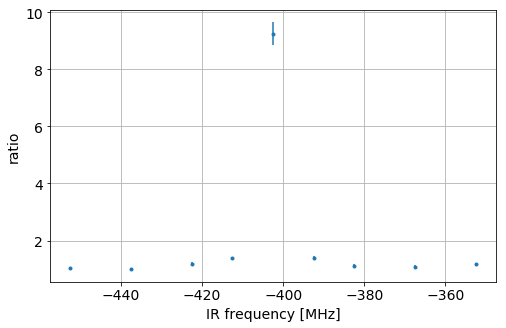

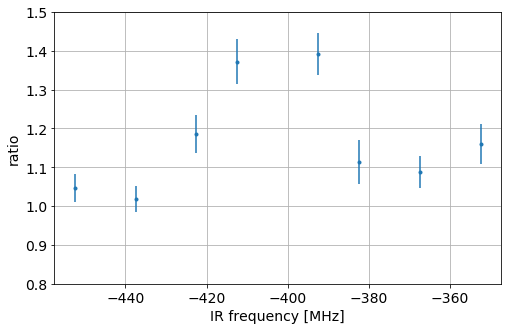

In [159]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)


fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)
ax.set_ylim(ymin = 0.8, ymax = 1.5)

## Scan R0 F1 RC with R0 F1 10 mW DET power
With phase modulation $\beta\approx 3.8$  

In [505]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [506]:
dset_idx = 9
dnames = [dset_names[dset_idx]]
devices = ('Laser Lock 1', )
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
         
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

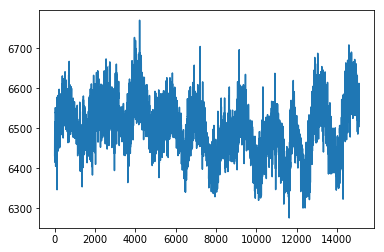

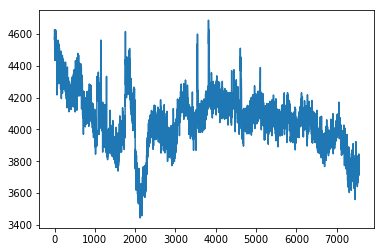

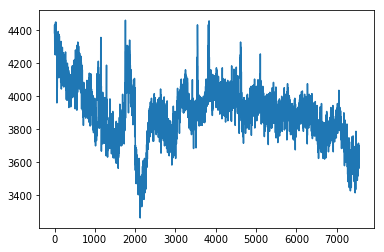

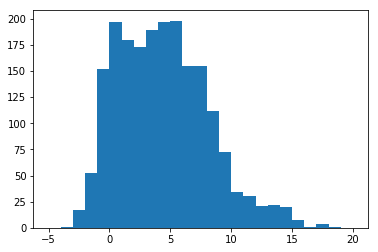

In [507]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [523]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 6
fl_cutoff = -1e6

In [524]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

69.5% data discarded


In [525]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

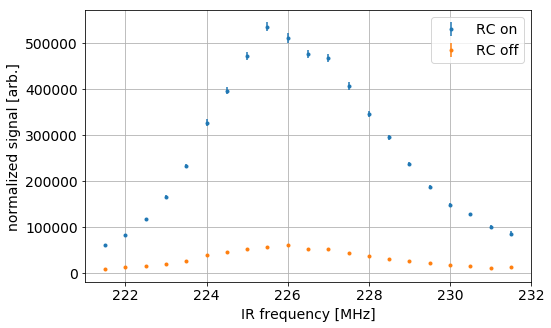

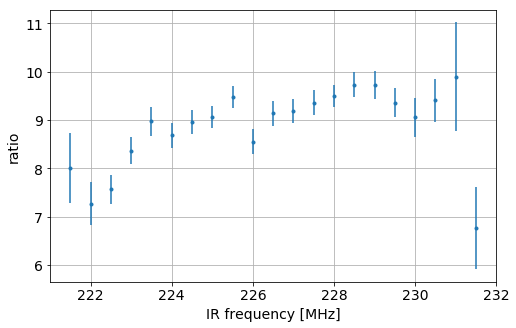

In [526]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

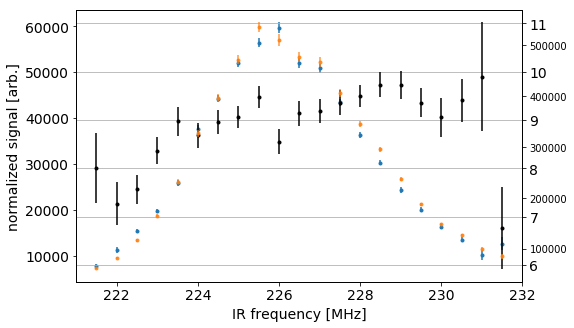

In [527]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')


ax1 = ax.twinx()
ax1.errorbar(bin_means, ratio, yerr = err, fmt = '.', color = 'k')

ax2 = ax.twinx()
ax2.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on', color = 'C1', alpha = 0.8)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
# ax.legend(fontsize = 14)

set_fontsize(ax, 14)
set_fontsize(ax1,14)
ax1.grid(True)

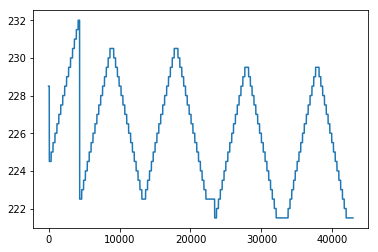

In [445]:
plt.plot(data_devices['Laser Lock 1']['laser 2 lockpoint'])

27.081748427397066

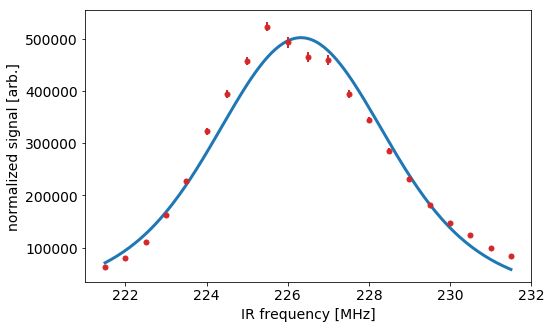

In [446]:
import lmfit

y = results[0][0]
yerr = results[0][1]

model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(y, bin_means)
params.add('c', 0)
result = model.fit(y, params = params, x = bin_means, weights = 1/yerr)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, y, yerr = yerr, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
result.redchi

10.162646464909031

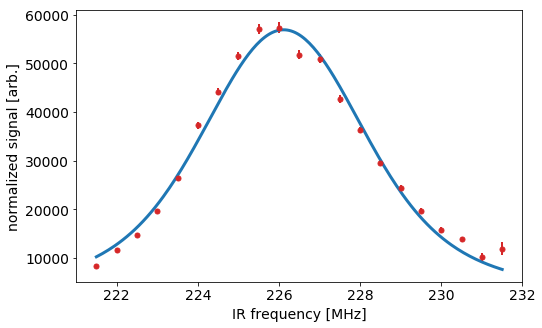

In [447]:
import lmfit

y = results[1][0]
yerr = results[1][1]

model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(y, bin_means)
params.add('c', 0)
result = model.fit(y, params = params, x = bin_means, weights = 1/yerr)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, y, yerr = yerr, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
result.redchi

In [451]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mc = mask_sh_closed & mask_frequency
    mo = mask_sh_open & mask_frequency
    d1 = fluorescence_integral[mo]/absorption_integral[mo]
    d2 = fluorescence_integral[mc]/absorption_integral[mc]
    stat.append(d1/d2)
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)

bin_means = np.unique(scan_parameters)

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


222.5 MHz: 7.78 gain


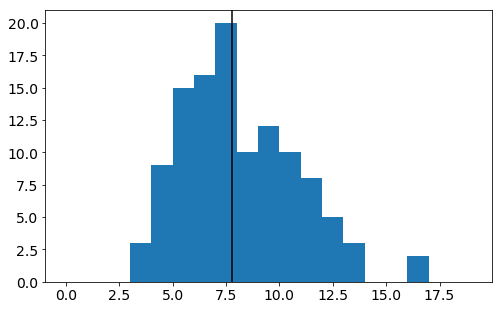

In [498]:
def aggr_fun(x):
    y = x.copy()
    y = y[y>0]
    y = y[y<30]
    return np.nanmedian(y)

idx = 2
d = stat[idx]
d = d[~np.isnan(d)]

bins = np.arange(0,20,1)
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(d, bins = bins);
ax.axvline(aggr_fun(d), color = 'k')
set_fontsize(ax, 14)
print(f"{bin_means[idx]} MHz: {aggr_fun(d):.2f} gain")

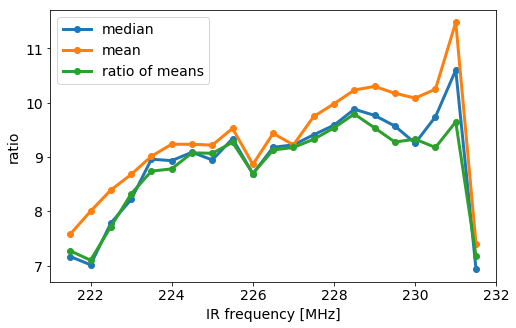

In [500]:
fig, ax = plt.subplots(figsize = (8,5))

def aggr_fun(x):
    y = x.copy()
    y = y[y>0]
    y = y[y<30]
    return np.nanmedian(y)

y = [aggr_fun(d) for d in stat]
ax.plot(bin_means, y, '.-', lw = 3, ms = 12, label = 'median')

def aggr_fun(x):
    y = x.copy()
    y = y[y>0]
    y = y[y<30]
    return np.nanmean(y)

y = [aggr_fun(d) for d in stat]
ax.plot(bin_means, y, '.-', lw = 3, ms = 12, label = 'mean')

ax.plot(bin_means, ratio, '.-', lw = 3, ms = 12, label = 'ratio of means')

ax.set_ylabel('ratio')
ax.set_xlabel('IR frequency [MHz]')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## Scan P2 F1 RC with R0 F1 10 mW DET power
With phase modulation $\beta\approx 3.8$ 

In [333]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [334]:
dset_idx = 10
dnames = [dset_names[dset_idx]]
devices = ('Laser Lock 1',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
         
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

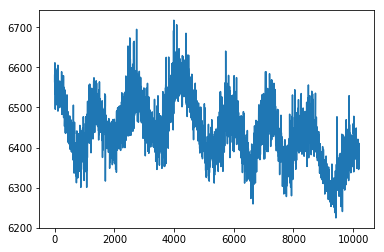

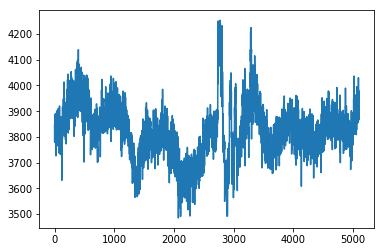

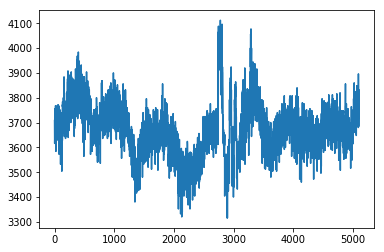

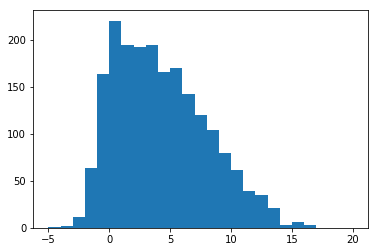

In [335]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [336]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -5000

In [337]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

60.8% data discarded


In [338]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

In [339]:
scan_res = {}
scan_res[dset_idx] = (bin_means, results)

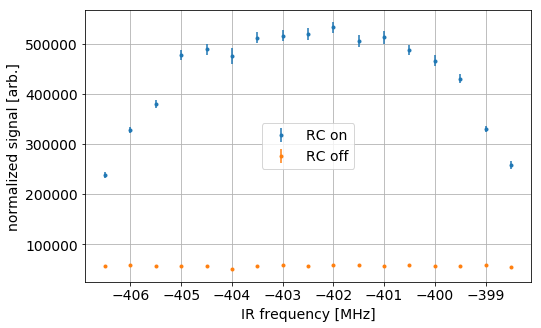

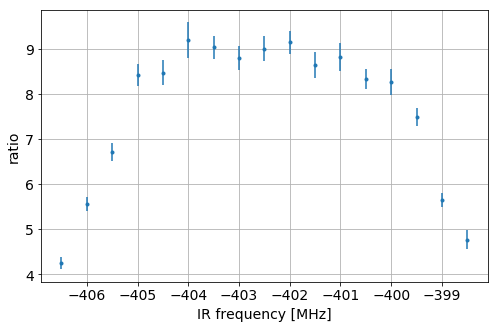

In [340]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


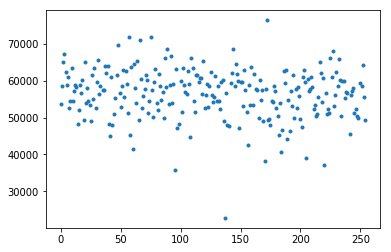

In [341]:
plt.plot(np.nanmean((fluorescence_integral[mask_sh_closed]/absorption_integral[mask_sh_closed]).reshape(-1,20), axis = 1), '.')

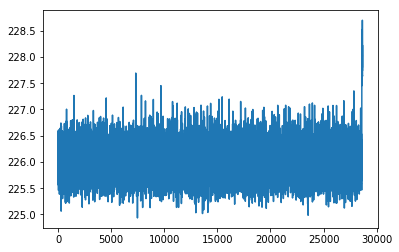

In [343]:
plt.plot(data_devices['Laser Lock 1']['laser 2 frequency'])

## Scan P2 F1 RC with R0 F1 10 mW DET power
With phase modulation $\beta\approx 3.8$  
offset R0 F1 by +2 MHz

In [344]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [349]:
dset_idx = 11
dnames = [dset_names[dset_idx]]
devices = ('Laser Lock 1', )
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
         
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

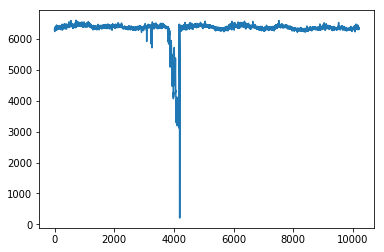

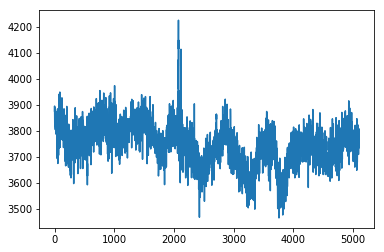

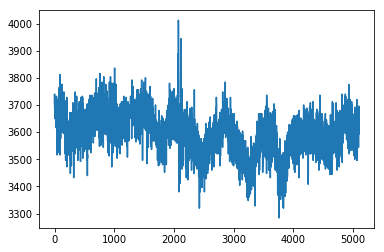

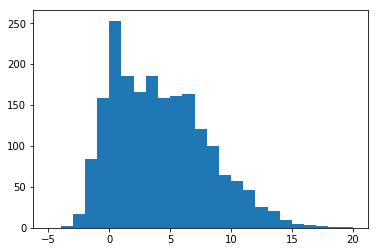

In [350]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [351]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -5000

In [352]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

61.7% data discarded


In [353]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

In [354]:
scan_res[dset_idx] = (bin_means, results)

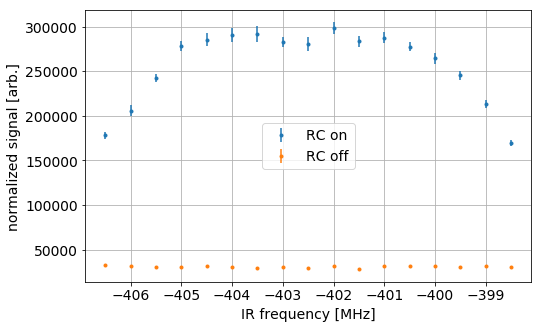

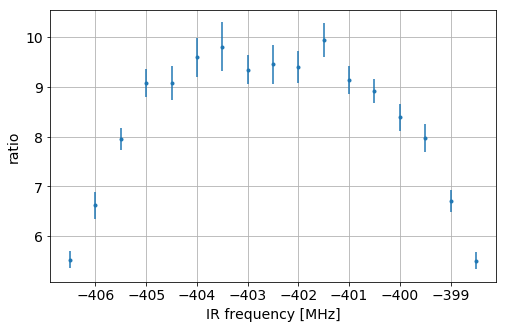

In [355]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

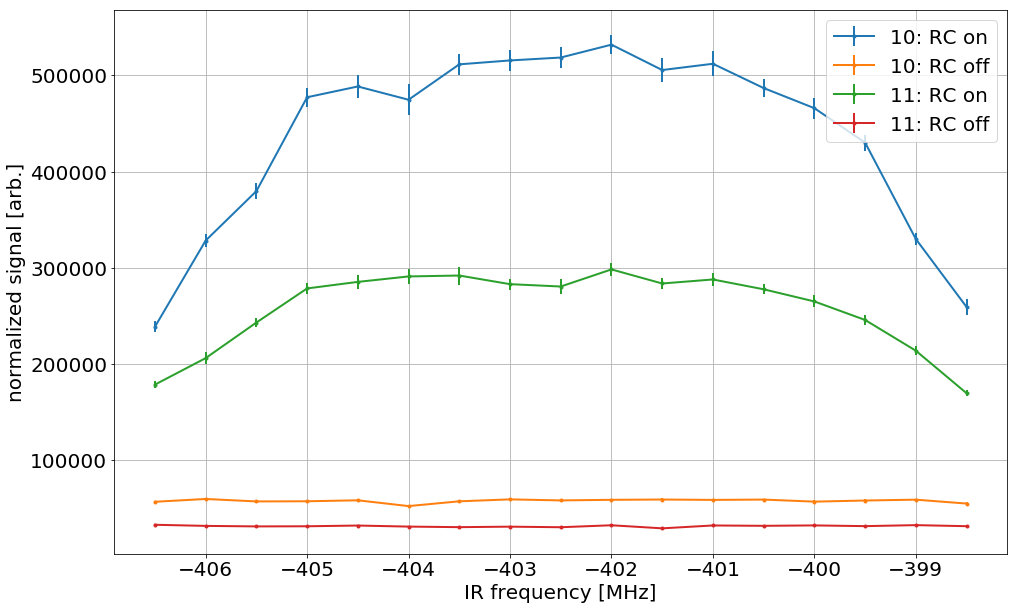

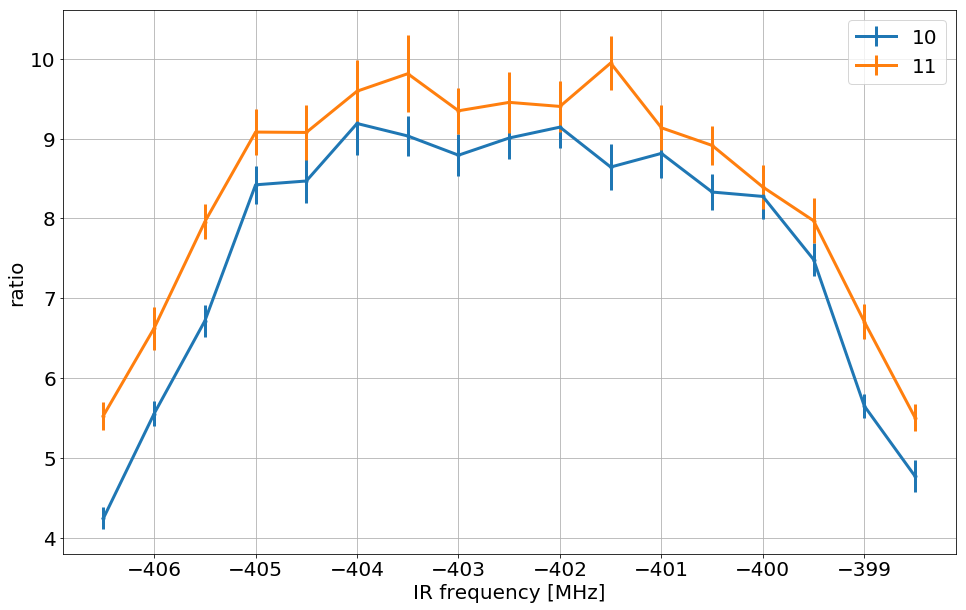

In [356]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm,r) in scan_res.items():
    ax.errorbar(bm, r[0][0], yerr = r[0][1], fmt = '.', label = f'{s}: RC on', lw = 2, ls = '-')
    ax.errorbar(bm, r[1][0], yerr = r[1][1], fmt = '.', label = f'{s}: RC off', lw = 2, ls = '-')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 20)

ax.grid(True)
set_fontsize(ax, 20)

fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan_res.items():
    ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
    ax.errorbar(bm, ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)

set_fontsize(ax, 20)

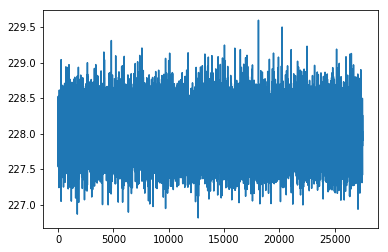

In [357]:
plt.plot(data_devices['Laser Lock 1']['laser 2 frequency'])